# TP5: Estimación de peso y dimensiones de los envíos de Mercado Libre

# Materia: Aprendizaje  no supervisado

## Análisis del dataset. Comunicación de resultados y conclusiones

A partir de lo visto en la teoría de la materia y del cuarto laboratorio, diagramar una comunicación en formato textual o interactivo describiendo la solución de las actividades propuestas a continuación. Al final de las mismas se proveen actividades opcionales (no obligatorias) que pueden resultar de interés.

### Actividades Propuestas:

    1. Aplicar PCA (Análisis de componentes principales) sobre el conjunto de features para reducir su dimensionalidad. Probar con distintos valores del parámetro que determina la cantidad de componentes finales (n_components), por ejemplo, 2, 5 y 10. Para cada versión resultante agregar el target y entrenar los 3 mejores modelos encontrados en el práctico anterior y reportar métricas. 
    
    Nota: Recordar que para PCA es importante que los features se encuentren normalizados, por lo que recomendamos usar StandardScaler.
    
    2. Aplicar K-Means para generar clustering sobre los siguientes features propuestos: SHP_WEIGHT (Peso físico del ítem) y SHP_LENGTH (Largo del ítem) (Probar distintos K: por ejemplo: 5, 10, 15). 
    
    Luego graficar con distintos colores los distintos dominios (variable DOMAIN_ID) dentro de cada cluster.

    Analizar:
    
        a. Cuales son los dominios más frecuentes de cada cluster
        b. Hay dominios que se encuentran en más de un cluster? Cuales?
    
    3. [Opcional] Aplicar otro algoritmo de clustering, como mixtura de gaussianas.
    
La comunicación debe estar apuntada a un público técnico pero sin conocimiento del tema particular, como por ejemplo, sus compañeros de clase o stakeholders del proyecto. Idealmente, además del documento se debería generar una presentación corta para stakeholders explicando el análisis realizado sobre los datos y las conclusiones obtenidas de tal análisis.
    
Se evaluarán los siguientes aspectos:

    ● El informe debe contener un mensaje claro y presentado de forma concisa.
    ● Los gráficos deben aplicar los conceptos de percepción visual vistos en clase.
    ● Se debe describir o estimar la significancia estadística de su trabajo.


## Carga de bibliotecas y datos

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import scipy as sc
from math import sqrt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, LabelBinarizer, StandardScaler
from ast import literal_eval
from pandas.io.json import json_normalize
from fancyimpute import KNN
#extras para TP5
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

%matplotlib inline

Using TensorFlow backend.


In [2]:
random.seed(0)
DATASET = '../meli_dataset_20190426.csv'
df_original = pd.read_csv(DATASET, low_memory=False)

In [3]:
df= df_original
df = df.head(10000)

## Preprocesamiento:  

En base a lo desarrollado en el TP2 se eliminan los registros con `STATUS` 404 o con faltantes en la variables `SHP`, se agrupa por `ITEM_ID` y se reemplaza por la mediana. Además, se codifican algunas variables categóricas y se imputan valores a los faltantes de la variable `PRICE`.

In [4]:
# Eliminación de registros con status 404
df = df[df.STATUS != "404"]
df = df.drop(columns=['STATUS'])
df.sample(5)

# Eliminación de registros con faltantes en las variables SHP 
df = df.dropna(subset=['SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT'])

# Agrupación por item id y reemplazo por mediana
# Agrupamos por item_id
df_grouped = df.groupby(['ITEM_ID'], as_index=False).median()
#Ordenamos el dataframe por item_id
df.sort_values('ITEM_ID', inplace = True)
# Eliminamos filas con item_id duplicados
df.drop_duplicates(subset='ITEM_ID', keep=False, inplace=True)
# Actualizamos dataframe original con la mediana de pesos y medidas
df.set_index('ITEM_ID', inplace=True)
df.update(df_grouped.set_index('ITEM_ID', inplace=True))
df.reset_index()

# Binarización de CATALOG_PRODUCT_ID, CONDITION y DOMAIN_ID

column = 'CATALOG_PRODUCT_ID'
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column])
#pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
CATALOG_PRODUCT_ID_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))

column = "CONDITION"
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
CONDITION_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))

column = 'DOMAIN_ID'
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
#pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
DOMAIN_ID_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
# Pegado de las variables categoricas codificadas al dataset
df["id"]=CONDITION_ENCODED.index
df=df.set_index("id")
df = pd.concat([df,CATALOG_PRODUCT_ID_ENCODED, CONDITION_ENCODED, DOMAIN_ID_ENCODED], axis=1)
df

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,...,DOMAIN_ID_MLB-WIRELESS_ANTENNAS,DOMAIN_ID_MLB-WIRELESS_CHARGERS,DOMAIN_ID_MLB-WIRELESS_FM_TRANSMITTERS,DOMAIN_ID_MLB-WIRE_STRIPPERS,DOMAIN_ID_MLB-WOMEN_SWIMWEAR,DOMAIN_ID_MLB-WRENCHES,DOMAIN_ID_MLB-WRENCH_SETS,DOMAIN_ID_MLB-WRISTWATCHES,DOMAIN_ID_MLB-XENON_KITS,DOMAIN_ID_nan
0,775.0,50.0,20.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-ENGINE_GASKET_SETS,750.00,QD3YJ9751S,...,0,0,0,0,0,0,0,0,0,0
1,6100.0,70.0,25.0,5.0,"[{'id': 'BEDDING_SET_SIZE', 'name': 'Tamanho',...",H53U1H7Q5G,new,MLB-BEDDING_SETS,119.90,J3EY3QAB29,...,0,0,0,0,0,0,0,0,0,0
2,464.0,20.0,11.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-AUTOMOBILE_FUEL_PUMPS,349.90,NO4W1R9S3D,...,0,0,0,0,0,0,0,0,0,0
3,150.0,25.0,25.0,11.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-PENDRIVES,21.99,KIQX6YQZI4,...,0,0,0,0,0,0,0,0,0,0
4,3719.0,42.0,34.0,13.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",GITRVCM7WO,used,MLB-GAME_CONSOLES,849.00,ZQIKYCCZ7E,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3987,431.0,25.0,25.0,5.0,"[{'id': 'CLOSING', 'name': 'Fecho', 'value_id'...",H53U1H7Q5G,new,MLB-FANNY_PACKS,69.90,GPWP5IFQEN,...,0,0,0,0,0,0,0,0,0,0
3988,150.0,20.0,20.0,20.0,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-PORTABLE_ELECTRIC_MASSAGERS,7.50,OFLRK20BUP,...,0,0,0,0,0,0,0,0,0,0
3989,3880.0,36.0,24.0,13.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-ENGINE_OILS,145.90,MQICEHKRH5,...,0,0,0,0,0,0,0,0,0,0
3990,1040.0,28.0,18.0,8.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",CCNZQYJ1G6,new,MLB-ROUTERS,329.49,ANYX5441IO,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Se guarda la columna DOMAIN_ID para usarla en los gráficos de clusters mas adelante
DOMAIN_ID=pd.DataFrame(data=df['DOMAIN_ID'])

In [6]:
DOMAIN_ID

,DOMAIN_ID
0,MLB-ENGINE_GASKET_SETS
1,MLB-BEDDING_SETS
2,MLB-AUTOMOBILE_FUEL_PUMPS
3,MLB-PENDRIVES
4,MLB-GAME_CONSOLES
...,...
3987,MLB-FANNY_PACKS
3988,MLB-PORTABLE_ELECTRIC_MASSAGERS
3989,MLB-ENGINE_OILS
3990,MLB-ROUTERS


In [7]:
# Imputación de faltantes de PRICE por KNN
df_numeric = df.select_dtypes([np.number])
df_filled = pd.DataFrame(KNN(3).fit_transform(df_numeric))
df_filled.columns=df_numeric.columns
df=df_filled

Imputing row 1/3992 with 0 missing, elapsed time: 209.839
Imputing row 101/3992 with 0 missing, elapsed time: 209.847
Imputing row 201/3992 with 0 missing, elapsed time: 209.854
Imputing row 301/3992 with 0 missing, elapsed time: 209.861
Imputing row 401/3992 with 0 missing, elapsed time: 209.867
Imputing row 501/3992 with 0 missing, elapsed time: 209.874
Imputing row 601/3992 with 0 missing, elapsed time: 209.881
Imputing row 701/3992 with 0 missing, elapsed time: 209.889
Imputing row 801/3992 with 0 missing, elapsed time: 209.897
Imputing row 901/3992 with 0 missing, elapsed time: 209.904
Imputing row 1001/3992 with 0 missing, elapsed time: 209.911
Imputing row 1101/3992 with 0 missing, elapsed time: 209.917
Imputing row 1201/3992 with 0 missing, elapsed time: 209.925
Imputing row 1301/3992 with 0 missing, elapsed time: 209.933
Imputing row 1401/3992 with 1 missing, elapsed time: 209.942
Imputing row 1501/3992 with 0 missing, elapsed time: 209.949
Imputing row 1601/3992 with 0 missin

In [8]:
df=df_filled

In [9]:
# división entre instancias y etiquetas

X, y, domain = df.iloc[:, 4:], df[['SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT']], DOMAIN_ID

# división entre entrenamiento y evaluación
#stratify=y no se emplea porque no es problema de clasificación
X_train, X_test, y_train, y_test, domain_train, domain_test  = train_test_split(X, y, domain, test_size=0.2, random_state=42)

# Actividad 1:    

Aplicar PCA (Análisis de componentes principales) sobre el conjunto de features para reducir su dimensionalidad. Probar con distintos valores del parámetro que determina la cantidad de componentes finales (n_components), por ejemplo, 2, 5 y 10. Para cada versión resultante agregar el target y entrenar los 3 mejores modelos encontrados en el práctico anterior y reportar métricas.

Nota: Recordar que para PCA es importante que los features se encuentren normalizados, por lo que recomendamos usar StandardScaler.

Primero se normalizan los features aplicando StandardScaler

In [10]:
scaled_features = StandardScaler().fit_transform(X_train.values)

In [11]:
scaled_features_X_train = pd.DataFrame(scaled_features, index=X_train.index, columns=X_train.columns)

In [12]:
scaled_features_X_train

,PRICE,CATALOG_PRODUCT_ID_A0RY70BE19,CATALOG_PRODUCT_ID_A2H2JJFBXM,CATALOG_PRODUCT_ID_A4M0AP2TSK,CATALOG_PRODUCT_ID_A6X73QCLS9,CATALOG_PRODUCT_ID_A7Y7QKJ7EF,CATALOG_PRODUCT_ID_ADKMKF0FVM,CATALOG_PRODUCT_ID_AF4WQUGCVH,CATALOG_PRODUCT_ID_AFPLIBE9VN,CATALOG_PRODUCT_ID_AG9UI846DP,...,DOMAIN_ID_MLB-WIRELESS_ANTENNAS,DOMAIN_ID_MLB-WIRELESS_CHARGERS,DOMAIN_ID_MLB-WIRELESS_FM_TRANSMITTERS,DOMAIN_ID_MLB-WIRE_STRIPPERS,DOMAIN_ID_MLB-WOMEN_SWIMWEAR,DOMAIN_ID_MLB-WRENCHES,DOMAIN_ID_MLB-WRENCH_SETS,DOMAIN_ID_MLB-WRISTWATCHES,DOMAIN_ID_MLB-XENON_KITS,DOMAIN_ID_nan
549,-0.223862,-0.0177,-0.0177,-0.0177,-0.0177,-0.025035,-0.0177,-0.0177,-0.0177,0.0,...,-0.0177,-0.035416,28.235616,-0.0177,-0.025035,-0.025035,0.0,-0.058796,-0.030667,-0.443089
557,-0.196569,-0.0177,-0.0177,-0.0177,-0.0177,-0.025035,-0.0177,-0.0177,-0.0177,0.0,...,-0.0177,-0.035416,-0.035416,-0.0177,-0.025035,-0.025035,0.0,-0.058796,-0.030667,-0.443089
1590,-0.142136,-0.0177,-0.0177,-0.0177,-0.0177,-0.025035,-0.0177,-0.0177,-0.0177,0.0,...,-0.0177,-0.035416,-0.035416,-0.0177,-0.025035,-0.025035,0.0,-0.058796,-0.030667,-0.443089
602,-0.151441,-0.0177,-0.0177,-0.0177,-0.0177,-0.025035,-0.0177,-0.0177,-0.0177,0.0,...,-0.0177,-0.035416,-0.035416,-0.0177,-0.025035,-0.025035,0.0,-0.058796,-0.030667,-0.443089
442,-0.286359,-0.0177,-0.0177,-0.0177,-0.0177,-0.025035,-0.0177,-0.0177,-0.0177,0.0,...,-0.0177,-0.035416,-0.035416,-0.0177,-0.025035,-0.025035,0.0,-0.058796,-0.030667,-0.443089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.022557,-0.0177,-0.0177,-0.0177,-0.0177,-0.025035,-0.0177,-0.0177,-0.0177,0.0,...,-0.0177,-0.035416,-0.035416,-0.0177,-0.025035,-0.025035,0.0,-0.058796,-0.030667,-0.443089
1294,0.190492,-0.0177,-0.0177,-0.0177,-0.0177,-0.025035,-0.0177,-0.0177,-0.0177,0.0,...,-0.0177,-0.035416,-0.035416,-0.0177,-0.025035,-0.025035,0.0,-0.058796,-0.030667,-0.443089
860,-0.289259,-0.0177,-0.0177,-0.0177,-0.0177,-0.025035,-0.0177,-0.0177,-0.0177,0.0,...,-0.0177,-0.035416,-0.035416,-0.0177,-0.025035,-0.025035,0.0,-0.058796,-0.030667,-0.443089
3507,-0.032477,-0.0177,-0.0177,-0.0177,-0.0177,-0.025035,-0.0177,-0.0177,-0.0177,0.0,...,-0.0177,-0.035416,-0.035416,-0.0177,-0.025035,-0.025035,0.0,-0.058796,-0.030667,2.256881


In [13]:
# se aplica PCA solo sobre la muestra de entrenamiento para evitar filtraciones
pca = PCA(n_components=5)
pca.fit(scaled_features_X_train)  
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  


[0.00283839 0.0020774  0.00178861 0.00171875 0.0017095 ]
[102.40049071  87.6044324   81.28746168  79.6843399   79.4694311 ]


In [14]:
pca = PCA(n_components=10)
pca.fit(scaled_features_X_train)  
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

[0.00283783 0.0021327  0.00179898 0.00172475 0.00171707 0.00171458
 0.00171307 0.00170871 0.00170625 0.00170552]
[102.39037219  88.76279138  81.52291292  79.82314246  79.64533751
  79.58756804  79.5524996   79.45107598  79.39394971  79.37703158]


In [15]:
pca = PCA(n_components=15)
pca.fit(scaled_features_X_train)  
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_) 

[0.00283805 0.00213847 0.00184762 0.00175107 0.00172154 0.00172039
 0.00171825 0.00171506 0.00171165 0.00170972 0.00170642 0.00170111
 0.00169705 0.00169549 0.0016912 ]
[102.39442247  88.88280982  82.61759238  80.42993752  79.7488542
  79.72230653  79.67257621  79.59865811  79.51952448  79.47467699
  79.39796492  79.27423515  79.17965715  79.14316766  79.04296885]


Ningún componente principal explica un porcentaje alto de la varianza!

# Actividad 2

Aplicar K-Means para generar clustering sobre los siguientes features propuestos: SHP_WEIGHT (Peso físico del ítem) y SHP_LENGTH (Largo del ítem) (Probar distintos K: por ejemplo: 5, 10, 15). 
    
    Luego graficar con distintos colores los distintos dominios (variable DOMAIN_ID) dentro de cada cluster.

    Analizar:
    
        a. Cuales son los dominios más frecuentes de cada cluster
        b. Hay dominios que se encuentran en más de un cluster? Cuales?

[0 0 0 ... 0 0 0]
[[  577.86531842    25.76975043]
 [11858.22881356    57.76949153]
 [19989.6122449     57.42040816]
 [ 3030.09710744    41.66818182]
 [ 6694.57798165    52.73394495]]


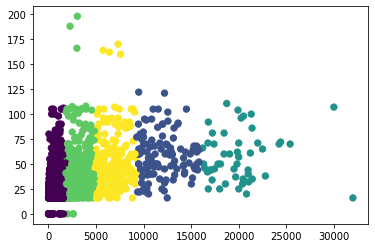

In [39]:
kmeans5=KMeans(n_clusters=5).fit(y_train[['SHP_WEIGHT','SHP_LENGTH']])
print(kmeans5.labels_)
print(kmeans5.cluster_centers_)
#kmeans.predict([[0, 0], [12, 3]])
plt.scatter(y_train['SHP_WEIGHT'], y_train['SHP_LENGTH'], c=kmeans5.labels_, s=40, cmap='viridis')

[6 1 1 ... 6 6 6]
[[7.10952941e+03 5.35294118e+01]
 [1.16038063e+03 3.09167804e+01]
 [1.65470882e+04 5.46352941e+01]
 [4.65344608e+03 4.77490196e+01]
 [1.27572500e+04 6.11416667e+01]
 [3.10000000e+04 6.15000000e+01]
 [3.29412531e+02 2.35843052e+01]
 [2.63270958e+03 4.02622754e+01]
 [2.11100000e+04 5.82962963e+01]
 [9.80691250e+03 5.56875000e+01]]


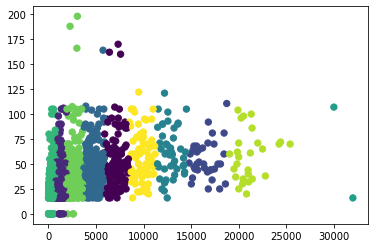

In [40]:
kmeans10=KMeans(n_clusters=10).fit(y_train[['SHP_WEIGHT','SHP_LENGTH']])
print(kmeans10.labels_)
print(kmeans10.cluster_centers_)
plt.scatter(y_train['SHP_WEIGHT'], y_train['SHP_LENGTH'], c=kmeans10.labels_, s=40, cmap='viridis')

[8 5 5 ... 8 0 0]
[[6.57807947e+02 2.74215894e+01]
 [7.89822973e+03 5.64459459e+01]
 [1.50670833e+04 5.51666667e+01]
 [3.26951765e+03 4.38729412e+01]
 [2.05514286e+04 5.70952381e+01]
 [1.27092000e+03 3.20071111e+01]
 [1.00421667e+04 5.49696970e+01]
 [6.25397647e+03 5.27882353e+01]
 [2.13333029e+02 2.19757299e+01]
 [2.17438655e+03 3.71365546e+01]
 [3.10000000e+04 6.15000000e+01]
 [1.24584000e+04 6.16950000e+01]
 [4.63684459e+03 4.67060811e+01]
 [1.75817368e+04 5.58210526e+01]
 [2.38680000e+04 6.30000000e+01]]


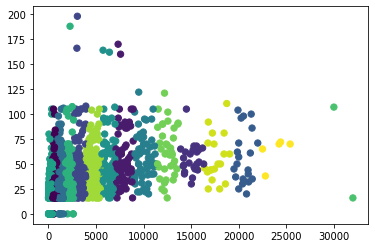

In [41]:
kmeans15=KMeans(n_clusters=15).fit(y_train[['SHP_WEIGHT','SHP_LENGTH']])
print(kmeans15.labels_)
print(kmeans15.cluster_centers_)
plt.scatter(y_train['SHP_WEIGHT'], y_train['SHP_LENGTH'], c=kmeans15.labels_, s=40, cmap='viridis')

In [19]:
df_cluster= y_train.copy()
df_cluster['CLUSTER']=pd.DataFrame(data=kmeans5.labels_) 
df_cluster['DOMAIN_ID']=pd.DataFrame(data=domain_train) 
#df_cluster.CLUSTER.unique()

In [20]:
df_cluster['DOMAIN_ID']

549                        MLB-WIRELESS_FM_TRANSMITTERS
557                                  MLB-SPORT_LEGGINGS
1590                            MLB-ELECTRICAL_SUPPLIES
602                               MLB-MOTORCYCLE_GLOVES
442     MLB-HOME_APPLIANCES_ACCESSORIES_AND_SPARE_PARTS
                             ...                       
1130                                 MLB-CEILING_LIGHTS
1294                            MLB-VEHICLE_ACCESSORIES
860              MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS
3507                                                NaN
3174                                    MLB-SPARK_PLUGS
Name: DOMAIN_ID, Length: 3193, dtype: object

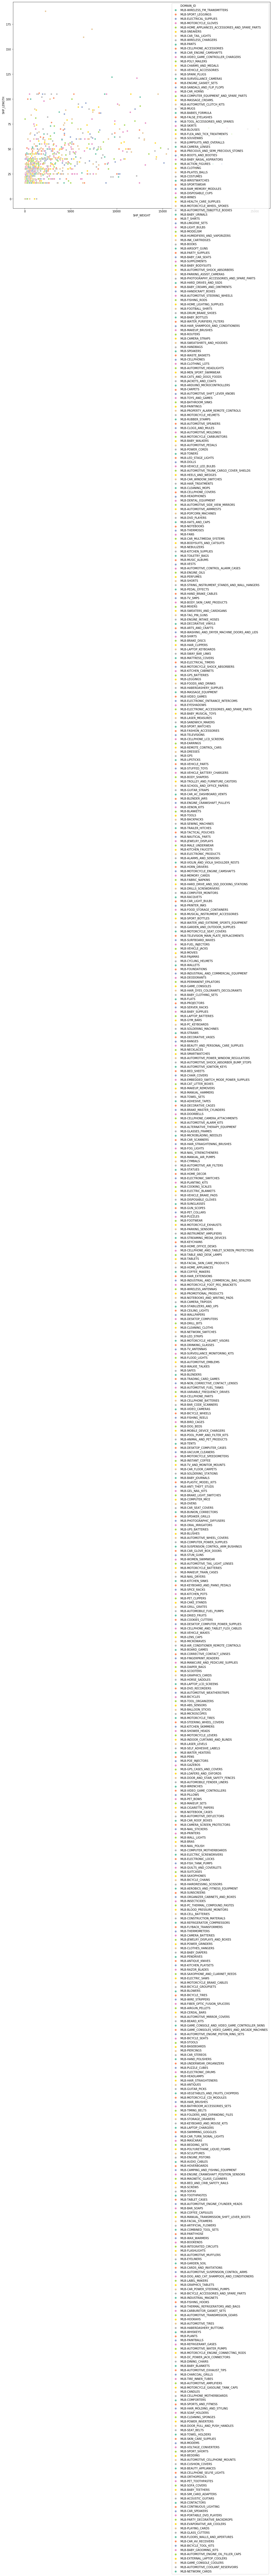

In [28]:
plt.figure(figsize=(17,14))
dfc=df_cluster[df_cluster.CLUSTER==0]
seaborn.scatterplot('SHP_WEIGHT', 'SHP_LENGTH', hue='DOMAIN_ID', legend='brief', palette="Set2", data=dfc)

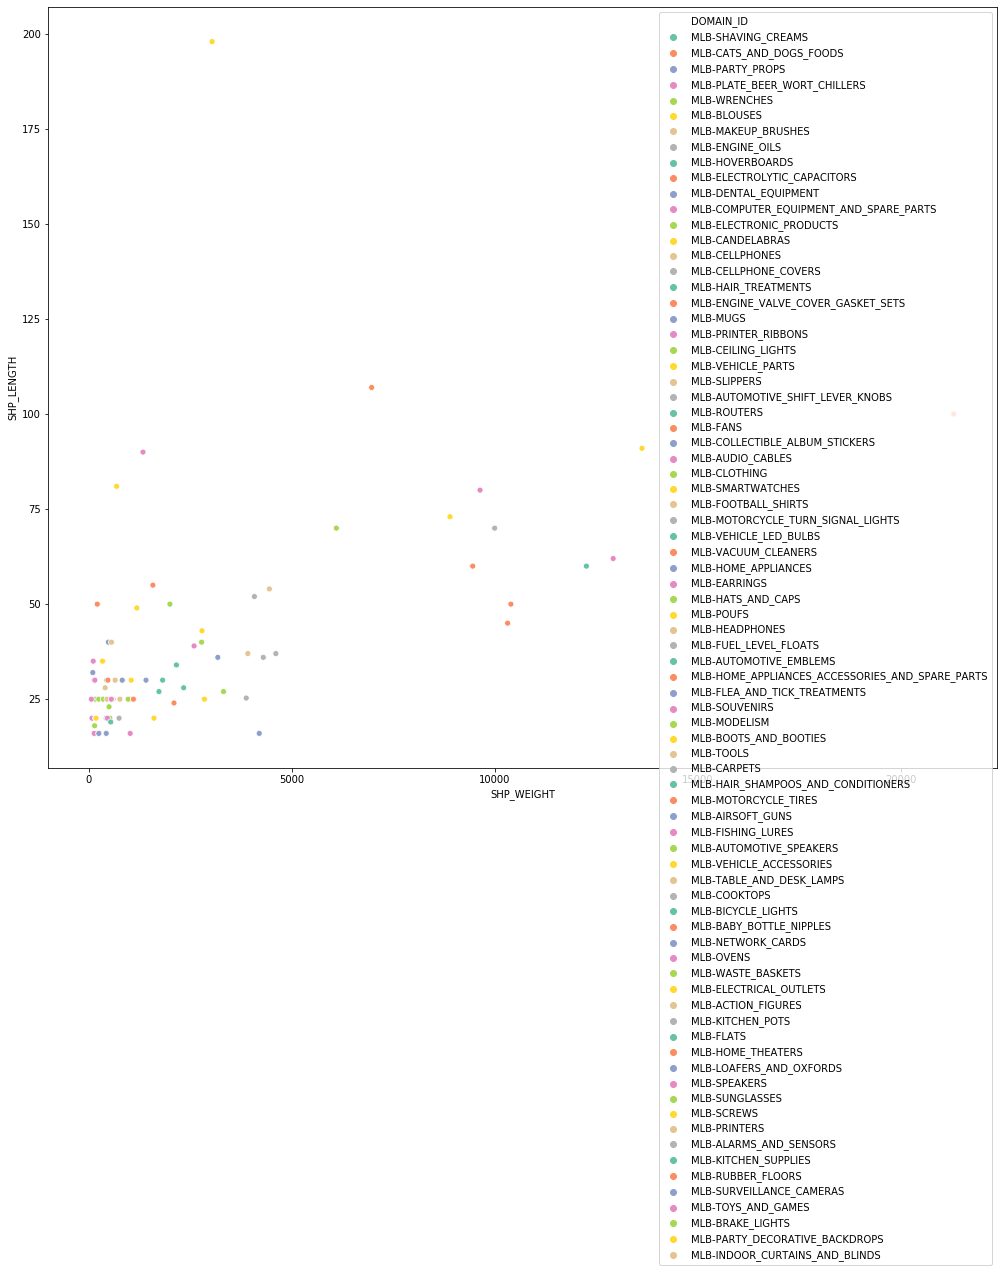

In [29]:
plt.figure(figsize=(17,14))
dfc=df_cluster[df_cluster.CLUSTER==1]
seaborn.scatterplot('SHP_WEIGHT', 'SHP_LENGTH', hue='DOMAIN_ID', legend='brief', palette="Set2", data=dfc)

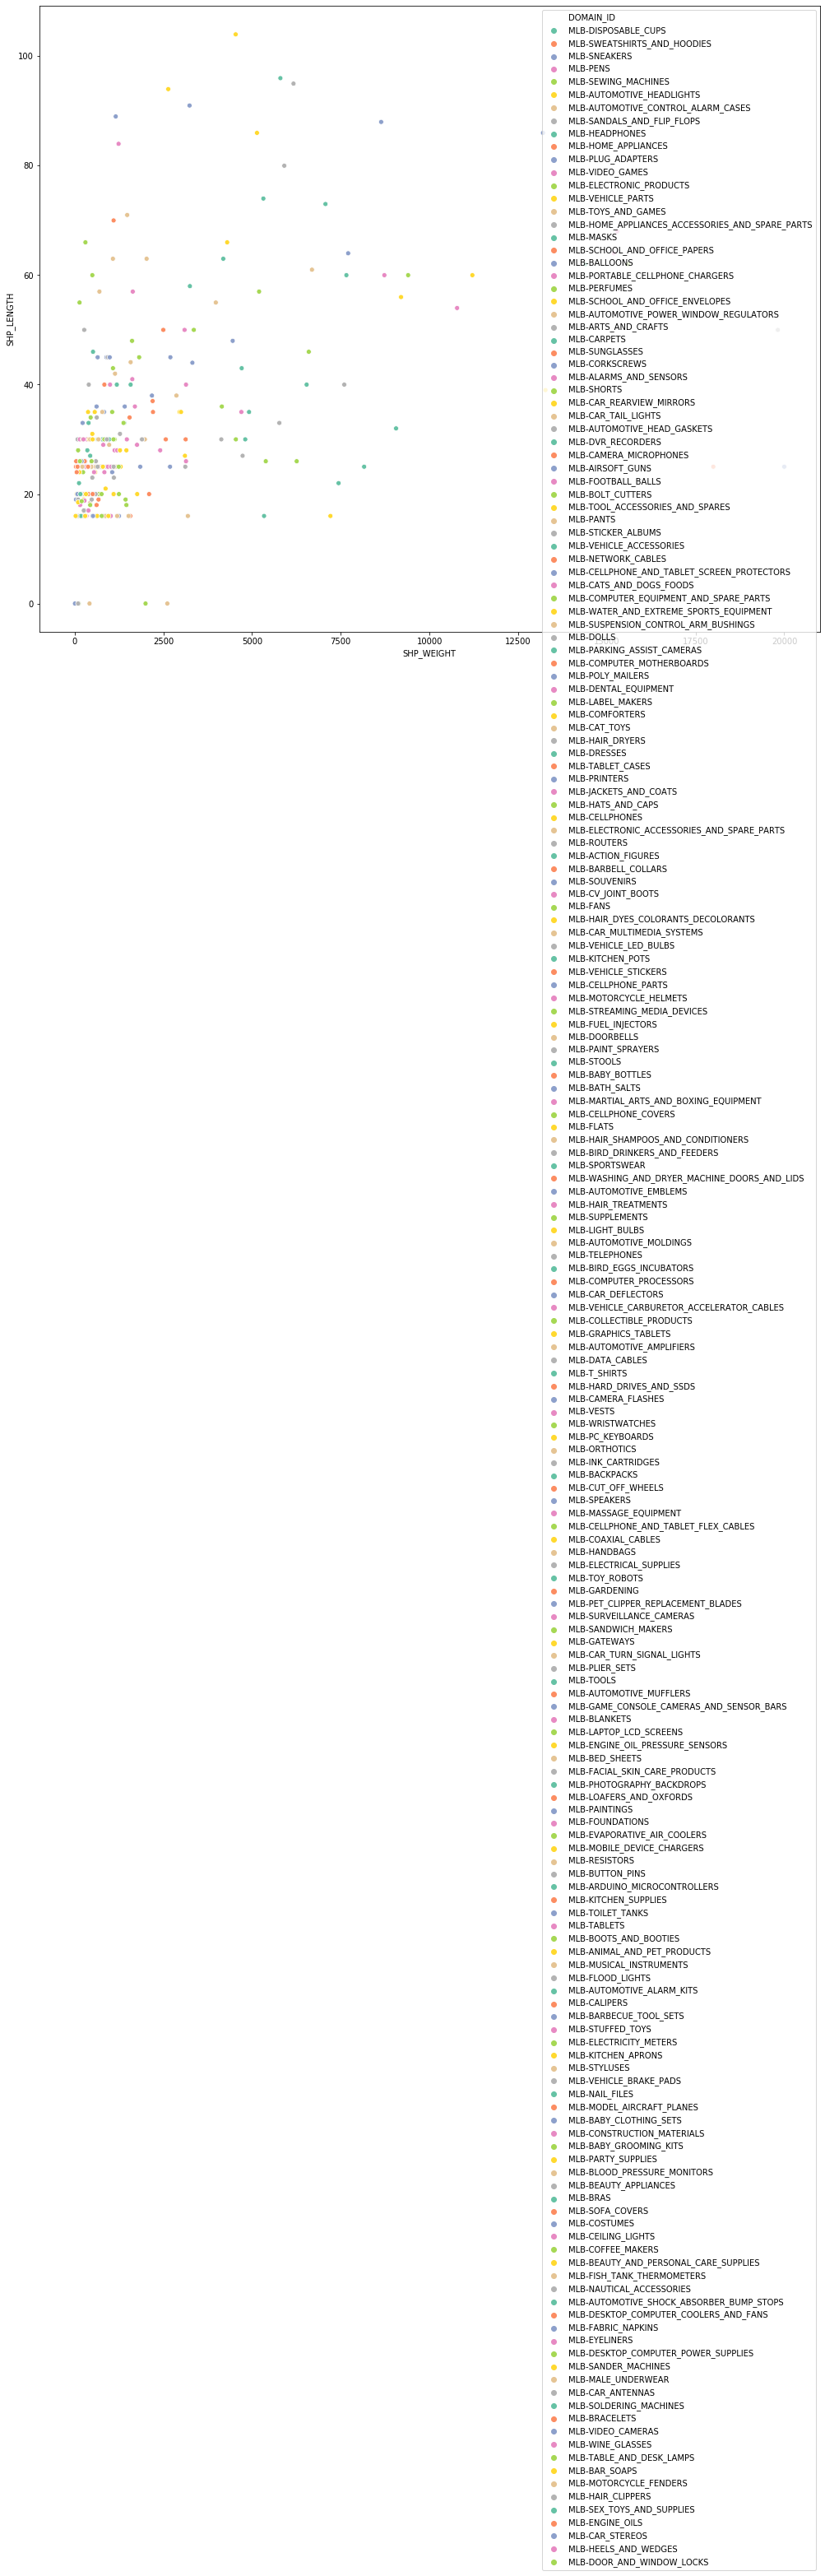

In [30]:
plt.figure(figsize=(17,14))
dfc=df_cluster[df_cluster.CLUSTER==2]
seaborn.scatterplot('SHP_WEIGHT', 'SHP_LENGTH', hue='DOMAIN_ID', legend='brief', palette="Set2", data=dfc)

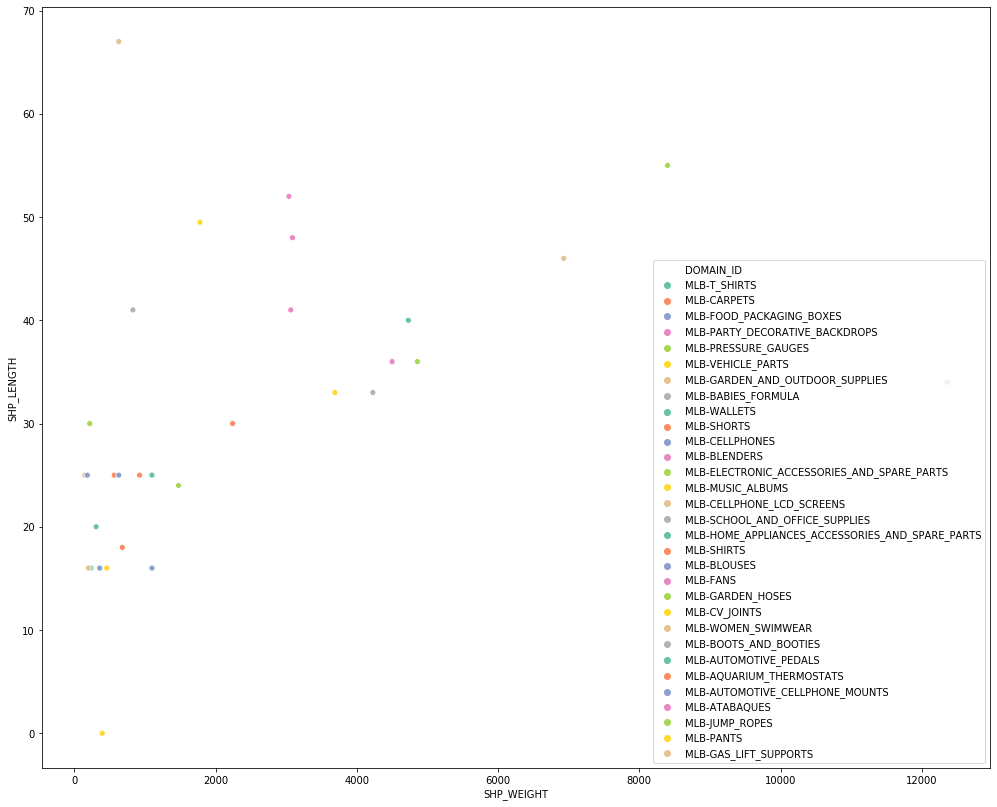

In [31]:
plt.figure(figsize=(17,14))
dfc=df_cluster[df_cluster.CLUSTER==3]
seaborn.scatterplot('SHP_WEIGHT', 'SHP_LENGTH', hue='DOMAIN_ID', legend='brief', palette="Set2", data=dfc)

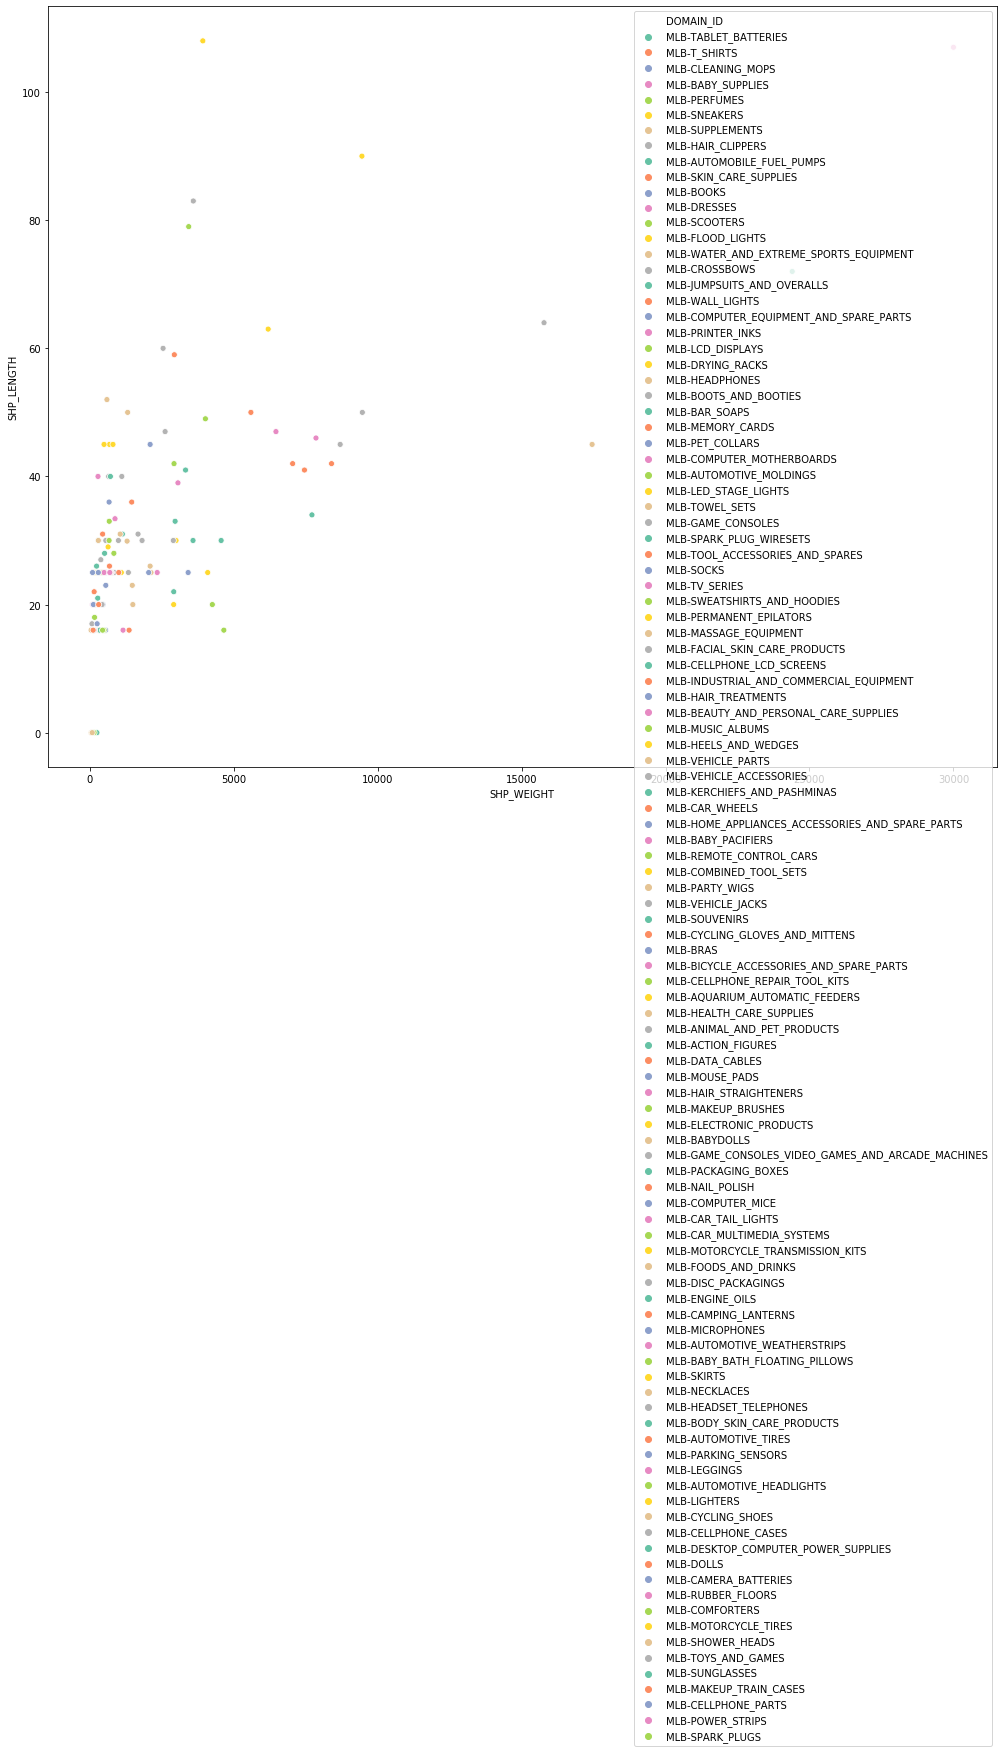

In [32]:
plt.figure(figsize=(17,14))
dfc=df_cluster[df_cluster.CLUSTER==4]
seaborn.scatterplot('SHP_WEIGHT', 'SHP_LENGTH', hue='DOMAIN_ID', legend='brief', palette="Set2", data=dfc)

# Actividad 3. [Opcional] 

Aplicar otro algoritmo de clustering, como mixtura de gaussianas.

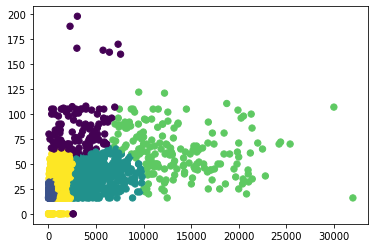

In [42]:
gm5 = GaussianMixture(n_components=5).fit(y_train[['SHP_WEIGHT','SHP_LENGTH']])
labels =gm5.predict(y_train[['SHP_WEIGHT','SHP_LENGTH']])
plt.scatter(y_train['SHP_WEIGHT'], y_train['SHP_LENGTH'], c=labels, s=40, cmap='viridis')

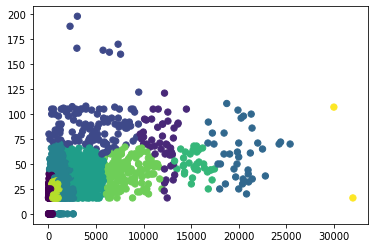

In [45]:
gm10 = GaussianMixture(n_components=10).fit(y_train[['SHP_WEIGHT','SHP_LENGTH']])
labels =gm10.predict(y_train[['SHP_WEIGHT','SHP_LENGTH']])
plt.scatter(y_train['SHP_WEIGHT'], y_train['SHP_LENGTH'], c=labels, s=40, cmap='viridis')

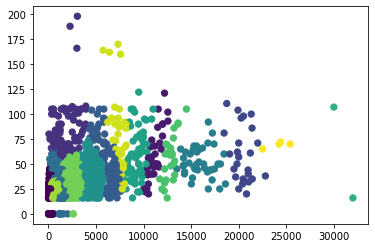

In [46]:
gm15 = GaussianMixture(n_components=15).fit(y_train[['SHP_WEIGHT','SHP_LENGTH']])
labels =gm15.predict(y_train[['SHP_WEIGHT','SHP_LENGTH']])
plt.scatter(y_train['SHP_WEIGHT'], y_train['SHP_LENGTH'], c=labels, s=40, cmap='viridis')